In [ ]:
##originalone

#!/usr/bin/env python
# coding: utf-8

# In[1]:


from builtins import range, input
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
 
from glob import glob
import pandas as pd
 
from sklearn.model_selection import train_test_split


# In[29]:


import os
path = list()
target = list()

for root, _, filenames in os.walk('fer2013_cls3/train'):
   
    for filename in filenames:
        
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg'):
           # print('Hello')
            full_path = os.path.join(root,filename)
            print(full_path)
            image_target_class = full_path.split('\\')[-2]
            print(image_target_class)
            print(os.path.join(root,filename))
            path.append(full_path)
            target.append(image_target_class)
print('Done!')

for root, _, filenames in os.walk('fer2013_cls3/test'):
   
    for filename in filenames:
        
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg'):
           # print('Hello')
            full_path = os.path.join(root,filename)
            print(full_path)
            image_target_class = full_path.split('\\')[-2]
            print(image_target_class)
            print(os.path.join(root,filename))
            path.append(full_path)
            target.append(image_target_class)
print('Done!')


# In[17]:


df = pd.DataFrame(data=zip(path,target),columns=['path','target'])
df.head()


# In[11]:


df.groupby('target').count()


# In[10]:


train_df, valid_df = train_test_split(
    df,
    stratify = df['target'],
    test_size = 0.2,
    random_state=42
)


# In[9]:


print(train_df.shape)
print(valid_df.shape)
print(train_df.target.value_counts())
print(valid_df.target.value_counts())


# In[7]:


target_size = (124,124)
input_image_size = (124,124,3)
batch_size = 10

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip = True,
)

train_iterator = datagen.flow_from_dataframe(
    train_df,
    target_size = target_size,
    x_col='path',
    y_col='target',
    seed=42,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

validation_iterator = train_datagen.flow_from_dataframe(
    valid_df,
    target_size = target_size,
    x_col='path',
    y_col='target',
    seed=42,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

print(train_iterator)
print(validation_iterator)


# In[8]:


# confirm the scaling works
batchX, batchY = train_iterator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))


# In[9]:


base_model = VGG19(
    input_shape = (124,124,3),
    include_top = False,
    weights = 'imagenet'
)
for layer in base_model.layers:
  layer.trainable = False

x = base_model.output
x = Flatten()(x)
# x = Dense(1024, activation = 'relu')(x)
# x = Dense(512,activation='relu')(x)
# x = Dense(64,activation='relu')(x)
x = Dropout(0.3)(x)
# x = Dense(32,activation='relu')(x)
# x = Dense(16,activation='relu')(x)
# x = Dense(8,activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model_final = Model(base_model.input,predictions)

model_final.compile(
    'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# In[10]:


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./VGG19ModelCheckPoints/',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)


# In[11]:


hist = model_final.fit(
    train_iterator,
    validation_data = validation_iterator,
    steps_per_epoch = train_iterator.samples//train_iterator.batch_size,
    validation_steps = validation_iterator.samples//validation_iterator.batch_size,
    epochs = 100,
    callbacks=[model_checkpoint_callback]
)


# In[12]:


model_final.save('myvgg19.h5')


# In[13]:


model_final.save('vgg19Model')


# In[14]:


# evaluating validation data on the model
model_final.evaluate_generator(
    generator=validation_iterator,
    steps=validation_iterator.samples//validation_iterator.batch_size,
    verbose=1
)


# # Plotting Model Loss & Accuracy 

# In[15]:


plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'],label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.savefig("result/loss_arr_fer.png")
plt.savefig("result/loss_arr_fer.eps",format='eps',bbox_inches='tight')
plt.show()


# # Model Performance Analysis

# In[16]:


# predicting on the validation images
preds_on_validation_data = model_final.predict(validation_iterator)
len(preds_on_validation_data)
# getting the maximum probabilites among the predicted one
max_pred_on_validation_data = np.argmax(preds_on_validation_data,axis=1)
max_pred_on_validation_data[:10]


# In[17]:


from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(validation_iterator.classes, max_pred_on_validation_data))
mat = confusion_matrix(validation_iterator.classes, max_pred_on_validation_data)
print('Classification Report')
target_names = ['Negative', 'Positive', 'Neutral']
print(classification_report(validation_iterator.classes, max_pred_on_validation_data, target_names=target_names))


# In[18]:


ax= plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Negative', 'Positive','neutral']); ax.yaxis.set_ticklabels(['Negative', 'Positive', 'Neutral']);


# # Testing on whole dataset

# In[23]:


test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='path',
    y_col='target',
    batch_size=10,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=(124,124)
)


# In[24]:


model_final.evaluate_generator(
    generator=test_generator,
    steps=test_generator.samples//test_generator.batch_size
)


# In[25]:


preds = model_final.predict(test_generator)
len(preds)
# predictions for test data
pred = np.argmax(preds,axis=1)
pred[:10]


# In[26]:


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, pred))
mat = confusion_matrix(test_generator.classes, pred)
print('Classification Report')
target_names = ['Negative', 'Positive', 'neutral']
print(classification_report(test_generator.classes, pred, target_names=target_names))


# In[27]:


ax= plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Negative', 'Positive', 'neutral']); ax.yaxis.set_ticklabels(['Negative', 'Positive', 'Neutral']);


# In[70]:


for i in range(10):
    img,label = test_generator.next()
    plt.imshow(img[0])
    name = 'result/img_fer_' + str(i) + '.png'
    print(name)
    plt.savefig(name)
    plt.show()


# In[73]:


final_outcomes = zip(df['target'],pred,test_generator.classes)


# In[75]:


final_df = pd.DataFrame(final_outcomes,columns=['actual target','Predicted target','classes'])
final_df.head(10)


# In[76]:


final_df.tail(10)


# In[77]:


test_generator.class_indices


# In[ ]:





In [ ]:
#changed one

2024-06-03 03:55:43.384030: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 03:55:43.776447: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 03:55:44.470636: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 28709 validated image filenames belonging to 7 classes.
Found 7179 validated image filenames belonging to 7 classes.


2024-06-03 03:55:47.095991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 03:55:47.279759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 03:55:47.279911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/100


2024-06-03 03:55:50.363461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-06-03 03:55:50.970732: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-03 03:55:50.989034: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f37c58cf540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-03 03:55:50.989050: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-06-03 03:55:51.005070: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-03 03:55:51.153497: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

898/898 [==============================] - 16s 14ms/step - loss: 1.9086 - accuracy: 0.3010 - val_loss: 1.6139 - val_accuracy: 0.3668 - lr: 0.0010
Epoch 2/100
  6/898 [..............................] - ETA: 9s - loss: 1.6900 - accuracy: 0.3385 

/home/rajesh/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 [==============================] - 12s 14ms/step - loss: 1.6585 - accuracy: 0.3489 - val_loss: 1.5789 - val_accuracy: 0.3818 - lr: 0.0010
Epoch 3/100
898/898 [==============================] - 13s 14ms/step - loss: 1.6186 - accuracy: 0.3637 - val_loss: 1.5586 - val_accuracy: 0.3874 - lr: 0.0010
Epoch 4/100
898/898 [==============================] - 12s 14ms/step - loss: 1.6028 - accuracy: 0.3720 - val_loss: 1.5633 - val_accuracy: 0.3801 - lr: 0.0010
Epoch 5/100
898/898 [==============================] - 13s 14ms/step - loss: 1.5836 - accuracy: 0.3817 - val_loss: 1.5509 - val_accuracy: 0.3904 - lr: 0.0010
Epoch 6/100
898/898 [==============================] - 13s 14ms/step - loss: 1.5722 - accuracy: 0.3837 - val_loss: 1.5381 - val_accuracy: 0.3973 - lr: 0.0010
Epoch 7/100
898/898 [==============================] - 13s 14ms/step - loss: 1.5586 - accuracy: 0.3913 - val_loss: 1.5573 - val_accuracy: 0.3856 - lr: 0.0010
Epoch 8/100
898/898 [==============================] - 13s 14ms/

Epoch 48/100
898/898 [==============================] - 13s 14ms/step - loss: 1.3927 - accuracy: 0.4645 - val_loss: 1.4629 - val_accuracy: 0.4402 - lr: 3.2000e-07
Epoch 49/100
898/898 [==============================] - 14s 15ms/step - loss: 1.3945 - accuracy: 0.4645 - val_loss: 1.4633 - val_accuracy: 0.4418 - lr: 3.2000e-07
Epoch 50/100
895/898 [============================>.] - ETA: 0s - loss: 1.3924 - accuracy: 0.4651
Epoch 50: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
898/898 [==============================] - 13s 15ms/step - loss: 1.3921 - accuracy: 0.4652 - val_loss: 1.4628 - val_accuracy: 0.4403 - lr: 3.2000e-07
Epoch 51/100
898/898 [==============================] - 14s 15ms/step - loss: 1.3845 - accuracy: 0.4679 - val_loss: 1.4628 - val_accuracy: 0.4405 - lr: 6.4000e-08
Epoch 52/100
898/898 [==============================] - 14s 15ms/step - loss: 1.3921 - accuracy: 0.4632 - val_loss: 1.4628 - val_accuracy: 0.4405 - lr: 6.4000e-08
Epoch 53/100
897/898 [=

895/898 [============================>.] - ETA: 0s - loss: 1.3839 - accuracy: 0.4629
Epoch 86: ReduceLROnPlateau reducing learning rate to 2.6214401285682084e-16.
898/898 [==============================] - 13s 14ms/step - loss: 1.3839 - accuracy: 0.4629 - val_loss: 1.4628 - val_accuracy: 0.4417 - lr: 1.3107e-15
Epoch 87/100
898/898 [==============================] - 13s 14ms/step - loss: 1.3877 - accuracy: 0.4689 - val_loss: 1.4633 - val_accuracy: 0.4395 - lr: 2.6214e-16
Epoch 88/100
898/898 [==============================] - 13s 14ms/step - loss: 1.3901 - accuracy: 0.4647 - val_loss: 1.4632 - val_accuracy: 0.4392 - lr: 2.6214e-16
Epoch 89/100
894/898 [============================>.] - ETA: 0s - loss: 1.3859 - accuracy: 0.4665
Epoch 89: ReduceLROnPlateau reducing learning rate to 5.2428803630155353e-17.
898/898 [==============================] - 13s 15ms/step - loss: 1.3860 - accuracy: 0.4665 - val_loss: 1.4633 - val_accuracy: 0.4409 - lr: 2.6214e-16
Epoch 90/100
898/898 [=============

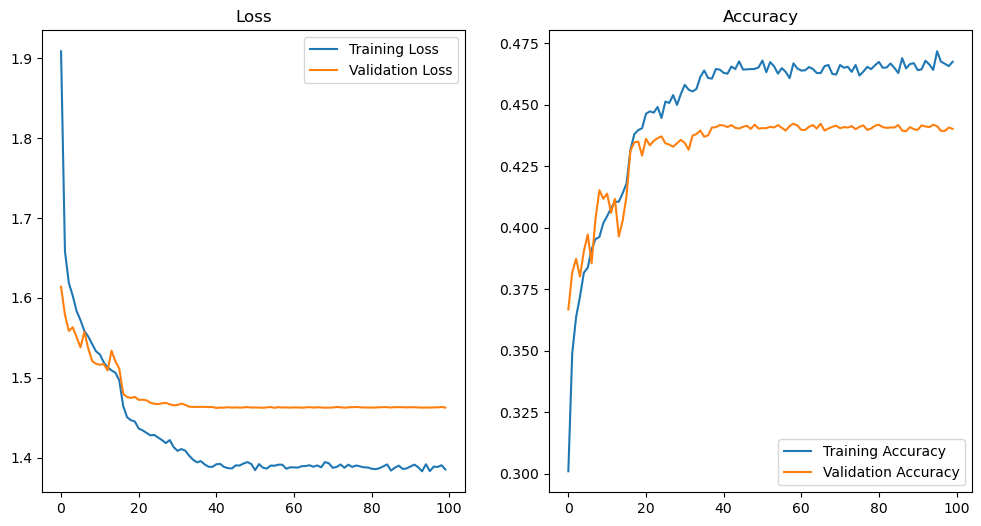

225/225 [==============================] - 2s 10ms/step
Confusion Matrix
[[112   6  74 330 160 166 110]
 [ 11   2   5  39  16  22  16]
 [115   4  87 331 183 186 118]
 [182   9 150 651 294 280 209]
 [144   5  81 465 204 198 136]
 [148   8  88 418 211 217 157]
 [ 81   7  68 316 128 137  94]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.12      0.13       958
     disgust       0.05      0.02      0.03       111
        fear       0.16      0.08      0.11      1024
       happy       0.26      0.37      0.30      1775
     neutral       0.17      0.17      0.17      1233
         sad       0.18      0.17      0.18      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.19      7179
   macro avg       0.15      0.15      0.15      7179
weighted avg       0.18      0.19      0.18      7179



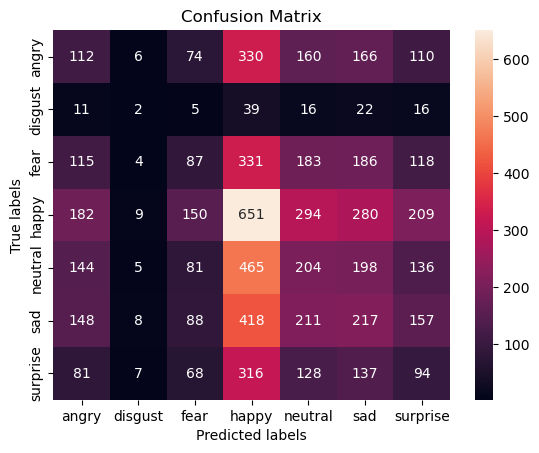

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Collecting paths and targets
def collect_paths_and_targets(folder):
    paths = []
    targets = []
    for root, _, filenames in os.walk(folder):
        for filename in filenames:
            if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg'):
                full_path = os.path.join(root, filename)
                image_target_class = full_path.split(os.sep)[-2]
                paths.append(full_path)
                targets.append(image_target_class)
    return paths, targets

train_folder = "/home/rajesh/Downloads/images/train"
val_folder = "/home/rajesh/Downloads/images/validation"

train_paths, train_targets = collect_paths_and_targets(train_folder)
val_paths, val_targets = collect_paths_and_targets(val_folder)

# Creating DataFrame
df_train = pd.DataFrame(data={'path': train_paths, 'target': train_targets})
df_val = pd.DataFrame(data={'path': val_paths, 'target': val_targets})

# Data Generators
target_size = (48, 48)
batch_size = 32

datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True)

train_iterator = datagen.flow_from_dataframe(df_train, target_size=target_size, x_col='path', y_col='target',
                                             seed=42, batch_size=batch_size, class_mode='categorical', shuffle=True)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

val_iterator = val_datagen.flow_from_dataframe(df_val, target_size=target_size, x_col='path', y_col='target',
                                               seed=42, batch_size=batch_size, class_mode='categorical', shuffle=True)

print(train_iterator)
print(val_iterator)

# Model using VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("model_vgg19.h5", monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)

# Training the model
epochs = 100

history = model.fit(train_iterator, validation_data=val_iterator, epochs=epochs, callbacks=[checkpoint, reduce_lr])

# Print training history
print(history.history)

# Plotting training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Evaluating the model on validation data
model.evaluate(val_iterator, steps=val_iterator.samples // val_iterator.batch_size, verbose=1)

# Predicting on validation data
preds_on_val_data = model.predict(val_iterator)
max_pred_on_val_data = np.argmax(preds_on_val_data, axis=1)

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(val_iterator.classes, max_pred_on_val_data)
print('Confusion Matrix')
print(conf_matrix)

target_names = list(val_iterator.class_indices.keys())
print('Classification Report')
print(classification_report(val_iterator.classes, max_pred_on_val_data, target_names=target_names))

# Heatmap of Confusion Matrix
ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
plt.show()


In [ ]:
## bath size 10

Found 28709 validated image filenames belonging to 7 classes.
Found 7179 validated image filenames belonging to 7 classes.
Epoch 1/100
2871/2871 [==============================] - ETA: 0s - loss: 2.1928 - accuracy: 0.3216

/home/rajesh/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2871/2871 [==============================] - 76s 26ms/step - loss: 2.1928 - accuracy: 0.3216 - val_loss: 1.4429 - val_accuracy: 0.4618 - lr: 1.0000e-04
Epoch 2/100
2871/2871 [==============================] - 72s 25ms/step - loss: 1.7701 - accuracy: 0.3924 - val_loss: 1.5239 - val_accuracy: 0.4311 - lr: 1.0000e-04
Epoch 3/100
2871/2871 [==============================] - 73s 25ms/step - loss: 1.6514 - accuracy: 0.4030 - val_loss: 1.3568 - val_accuracy: 0.4991 - lr: 1.0000e-04
Epoch 4/100
2871/2871 [==============================] - 73s 25ms/step - loss: 1.4678 - accuracy: 0.4562 - val_loss: 1.3576 - val_accuracy: 0.4723 - lr: 1.0000e-04
Epoch 5/100
2871/2871 [==============================] - 73s 25ms/step - loss: 1.4056 - accuracy: 0.4738 - val_loss: 1.2546 - val_accuracy: 0.5277 - lr: 1.0000e-04
Epoch 6/100
2871/2871 [==============================] - 73s 25ms/step - loss: 1.3479 - accuracy: 0.4983 - val_loss: 1.1912 - val_accuracy: 0.5589 - lr: 1.0000e-04
Epoch 7/100
2871/2871 [=====

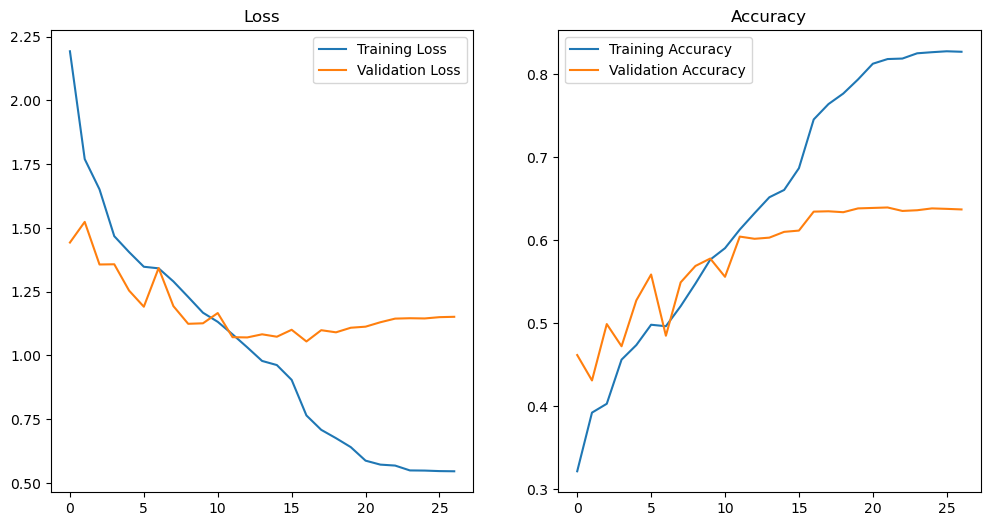

717/717 [==============================] - 14s 19ms/step - loss: 1.0553 - accuracy: 0.6346
Validation loss: 1.0553189516067505
Validation accuracy: 0.6345885396003723
718/718 [==============================] - 13s 18ms/step
Confusion Matrix
[[139  10  80 256 198 159 116]
 [ 19   0  17  22  26  17  10]
 [140  16 100 247 216 194 111]
 [227  25 176 478 359 346 164]
 [174  15 107 281 284 248 124]
 [173   8 121 314 244 240 147]
 [113   9  69 220 150 174  96]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.15      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.10      0.12      1024
       happy       0.26      0.27      0.27      1775
     neutral       0.19      0.23      0.21      1233
         sad       0.17      0.19      0.18      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.19      7179
   macro avg       0.15      0.

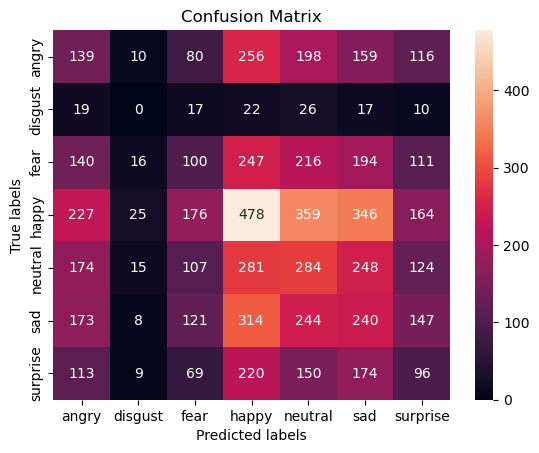

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Collecting paths and targets
def collect_paths_and_targets(folder):
    paths = []
    targets = []
    for root, _, filenames in os.walk(folder):
        for filename in filenames:
            if filename.endswith(('jpg', 'png', 'jpeg')):
                full_path = os.path.join(root, filename)
                image_target_class = full_path.split(os.sep)[-2]
                paths.append(full_path)
                targets.append(image_target_class)
    return paths, targets

train_folder = "/home/rajesh/Downloads/images/train"
val_folder = "/home/rajesh/Downloads/images/validation"

train_paths, train_targets = collect_paths_and_targets(train_folder)
val_paths, val_targets = collect_paths_and_targets(val_folder)

# Creating DataFrame
df_train = pd.DataFrame(data={'path': train_paths, 'target': train_targets})
df_val = pd.DataFrame(data={'path': val_paths, 'target': val_targets})

# Data Generators with Augmentation
target_size = (124, 124)
input_image_size = (124, 124, 3)
batch_size = 10

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_iterator = train_datagen.flow_from_dataframe(
    df_train,
    target_size=target_size,
    x_col='path',
    y_col='target',
    seed=42,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_iterator = val_datagen.flow_from_dataframe(
    df_val,
    target_size=target_size,
    x_col='path',
    y_col='target',
    seed=42,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Model using VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_image_size)

for layer in base_model.layers[:-4]:  # Unfreeze the top layers for fine-tuning
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Increased dropout rate
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Increased dropout rate
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("model_vgg19_best.h5", monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
epochs = 100

history = model.fit(train_iterator,
                    validation_data=val_iterator,
                    epochs=epochs,
                    callbacks=[checkpoint, reduce_lr, early_stopping])

# Print training history
print(history.history)

# Plotting training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Evaluating the model on validation data
val_loss, val_accuracy = model.evaluate(val_iterator, steps=val_iterator.samples // val_iterator.batch_size, verbose=1)
print(f'Validation loss: {val_loss}')
print(f'Validation accuracy: {val_accuracy}')

# Predicting on validation data
preds_on_val_data = model.predict(val_iterator)
max_pred_on_val_data = np.argmax(preds_on_val_data, axis=1)

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(val_iterator.classes, max_pred_on_val_data)
print('Confusion Matrix')
print(conf_matrix)

target_names = list(val_iterator.class_indices.keys())
print('Classification Report')
print(classification_report(val_iterator.classes, max_pred_on_val_data, target_names=target_names))

# Heatmap of Confusion Matrix
ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
plt.show()
